In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import emcee 
import corner

# Dados
## Lendo os dados e separando por cenário.


In [2]:
#pegando dados de Salvador
df = pd.read_csv('casos_mortes.csv') 

#Separando os dados do dataframe
casos_acumulados = df.CONFIRMADO.values
mortes = df.OBITO.values
data = df.DATA.values
mortes = mortes[:-309]
#removendo os erros dos dados 
for i in range(len(data)-1):
    if np.diff(casos_acumulados)[i] < 0:
        casos_acumulados[i]=casos_acumulados[i+1]

casos_diarios = np.diff(casos_acumulados)

# plt.scatter(data, casos_acumulados)

In [3]:
#Separando os dados por variantes

#primeira onda 
cen1 = casos_acumulados[0:231]
mcen1 = mortes[0:231]

#Variante gama
cen21 = casos_acumulados[231:518]
mcen21 = mortes[231:518]

#Variante delta
cen22 = casos_acumulados[518:649]
mcen22 = mortes[518:649]

#Variante ômicron
cen3 = casos_acumulados[649:749]
mcen3 = mortes[649:749]
len(mortes) - (len(mcen1)+len(mcen21)+len(mcen22)+len(mcen3))


0

# Plot
## Plotando os dados separados por variantes

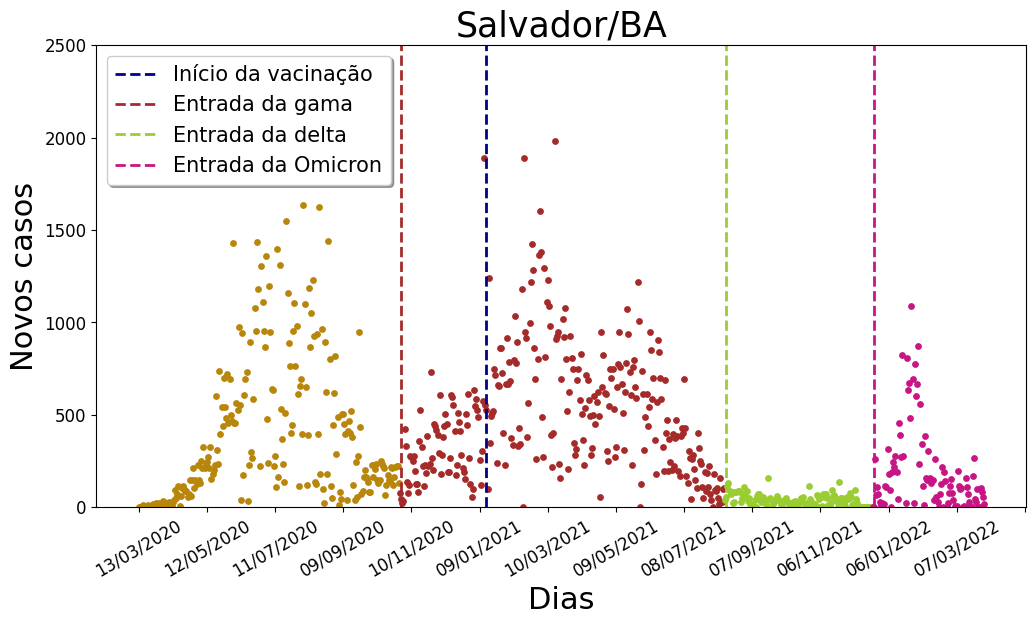

In [218]:
fig, ax = plt.subplots(figsize=(12,6))

ax.scatter(data[0:230],np.diff(cen1),c='darkgoldenrod', s=15)
ax.scatter(data[231:517],np.diff(cen21),c='brown', s=15)
ax.scatter(data[518:648],np.diff(cen22),c='yellowgreen', s=15)
ax.scatter(data[649:748],np.diff(cen3),c='mediumvioletred', s=15)
# ax.scatter(data,(casos), s=10, color='darkblue')

ax.axvline(data[307], 0, 600,c='darkblue',linestyle='--',label='Início da vacinação',linewidth=2)
ax.axvline(data[232], 0, 600,c='brown',linestyle='--',label='Entrada da gama',linewidth=2)
ax.axvline(data[519], 0, 600,c='yellowgreen',linestyle='--',label='Entrada da delta',linewidth=2)
ax.axvline(data[650], 0, 600,c='mediumvioletred',linestyle='--',label='Entrada da Omicron',linewidth=2)
ax.legend(loc='upper left',fontsize=15,shadow=True)
ax.tick_params(labelsize=12)

#Limiting the ammount of dates on the X axixs
ax.xaxis.set_major_locator(plt.MaxNLocator(15))
#Rotating the dates for better visualization
plt.setp(ax.get_xticklabels(), rotation=30)

ax.set_ylabel('Casos diários',fontsize=22)
ax.set_xlabel('Dias',fontsize=22)
ax.set_title('Salvador/BA',fontsize=25)

ax.set_ylim(0,2500)
plt.show()

# Fitting do modelo

### Modelo

In [6]:
def b(t,b0,b1,b2,t1,t2):
    if t<=t1:
        b=b0
    elif t2>=t>t1:
        b=b1
    elif t>t2:
        b=b2
    return b

def het_model(t,y,args):
    
    b0, b1, b2, t1, t2, k, d  = args
    
    fb = b(t,b0,b1,b2,t1,t2)
    
    S = y[0]
    E = y[1]
    I = y[2]
    R = y[3]
    D = y[4]
    Nc = y[5]
    Nd = y[6]
    
    g = 1/4
    eps=1/5.5
    
    dS_dt = -fb*I*(S/N)**(1+1/k)
    dE_dt = fb*I*(S/N)**(1+1/k) - eps*E
    dI_dt = eps*E - g*I - d*I
    dR_dt = g*I
    dD_dt = d*I
    
    dNc_dt = eps*E
    dNd_dt = d*I

    return[dS_dt, dE_dt, dI_dt, dR_dt, dD_dt, dNc_dt, dNd_dt]


### Cenário 1

#### Definindo das funções para rodar o MCMC para o primeiro cenário

In [7]:
N = 2886698 #população de salvador 2020 

def model(theta):
    b0, b1, b2, t1, t2, k, d, rr = theta
    params = b0, b1, b2, t1, t2, k, d
    sol = solve_ivp(fun = het_model, t_span = [0, len(cen1)], args=(params,),y0 = [N, 0, 1,0,0,0,0], t_eval=np.arange(len(cen1)))
    Nc = sol.y[5,:]
    Nd = sol.y[6,:]
    return np.r_[rr*Nc,Nd]

def lnlike(theta):
    return -0.5 * np.sum(((y1 - model(theta))/0.05) ** 2)

def lnprior(theta):
    b0, b1, b2, t1, t2, k, d, rr = theta
    if 0.0 < b0 < 2 and 0.0 < b1 < 2 and 0.0 < b2 < 2 and 10 < t1 < 50 and 150 < t2 < 200 and 0.0 < k < 300 and 0.0 < d < 0.6 and 0.01 < rr < 0.4:
        return 0.0
    return -np.inf

def lnprob(theta):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta)

def main(p0,nwalkers,niter,ndim,lnprob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 100)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter,progress=True)

    return sampler, pos, prob, state

In [8]:
nwalkers = 500
niter = 2000

#### Cenário 1

In [9]:

#Intervalo das condições iniciais para o cenário inicial

intervals= np.array(   [ [0, 2.], #b0
                         [0, 2.], #b1
                         [0, 2.], #b2
                         [10, 50], #t1
                         [150, 200], #t2
                         [0., 100], #k
                       [0,0.6], #d
                       [0.01,0.4]   #rr
                       ])
par0 = np.random.rand(len(intervals))
initial = intervals[:,0] + par0 * (intervals[:,1] - intervals[:,0])
ndim = len(initial)
p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]
yc = cen1
yd = mcen1
y1 = np.r_[cen1,mcen1]
sampler1, pos1, prob1, state1 = main(p0,nwalkers,niter,ndim,lnprob,y1)
samples1 = sampler1.flatchain
theta_max1  = samples1[np.argmax(sampler1.flatlnprobability)]
b0, b1, b2, t1, t2, k, d, rr0 = theta_max1
params = b0, b1, b2, t1, t2, k, d
sol1 = solve_ivp(fun = het_model, t_span = [0, len(yc)], args=(params,),y0= [N, 0, 1,0,0,0,0], t_eval=np.arange(len(yc)))
S1 = sol1.y[0,-1]
E1 = sol1.y[1,-1]
I1 = sol1.y[2,-1]
R1 = sol1.y[3,-1]
D1 = sol1.y[4,-1]
NC1 = sol1.y[5,-1]
ND1 = sol1.y[6,-1]

Running burn-in...
Running production...


  9%|██████▉                                                                      | 179/2000 [10:59<1:29:24,  2.95s/it]C:\Users\rober\AppData\Local\Temp\ipykernel_2324\4252325807.py:27: RuntimeWarning: invalid value encountered in scalar power
  dS_dt = -fb*I*(S/N)**(1+1/k)
C:\Users\rober\AppData\Local\Temp\ipykernel_2324\4252325807.py:28: RuntimeWarning: invalid value encountered in scalar power
  dE_dt = fb*I*(S/N)**(1+1/k) - eps*E
100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [1:35:17<00:00,  2.86s/it]


In [15]:
theta_max1

array([9.68401710e-01, 3.23062487e-01, 3.04721975e-01, 4.76038014e+01,
       1.51145065e+02, 2.52713781e+01, 6.40748801e-04, 8.16716807e-02])

### Cenário 2.1, 2.2, 3

#### Definindo das funções para rodar o MCMC para os outros cenários

In [10]:
def model_rho(theta):
    b0, b1, b2, t1, t2, k, d, rr, rho = theta
    params = b0, b1, b2, t1, t2, k, d
    sol = solve_ivp(fun = het_model, t_span = [0, len(yc)], args=(params,),y0 = [S+R*rho, E, I, R*(1-rho), D, NC, ND], t_eval=np.arange(len(yc)))
    Nc = sol.y[5,:]
    Nd = sol.y[6,:]
    return np.r_[rr*Nc,Nd]

def lnlike_rho(theta):
    return -0.5 * np.sum(((y_ex - model_rho(theta))/0.05) ** 2)

def lnprior_rho(theta):
    b0, b1, b2, t1, t2, k, d, rr, rho = theta
    if 0.0 < b0 < 2 and 0.0 < b1 < 2 and 0.0 < b2 < 2 and 10 < t1 < 50 and 150 < t2 < 200 and 0.01 < k < 300 and 0.0 < d < 0.6 and 0.01 < rr < 0.4 and 0. < rho < 1.:
        return 0.0
    return -np.inf

def lnprob_rho(theta):
    lp = lnprior_rho(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_rho(theta)

def main_rho(p0,nwalkers_rho,niter_rho,ndim_rho,lnprob_rho,y_ex):
    sampler = emcee.EnsembleSampler(nwalkers_rho, ndim_rho, lnprob_rho)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 100)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter_rho,progress=True)

    return sampler, pos, prob, state

In [11]:
nwalkers_rho = 500
niter_rho = 2000

In [12]:
#Intervalo das condições iniciais para os cenários 2.1, 2.2, 2.3

intervals_rho= np.array(   [ [0, 2.], #b0
                         [0, 2.], #b1
                         [0, 2.], #b2
                         [10, 50], #t1
                         [150, 200], #t2
                         [0.01, 100], #k
                       [0,0.6], #d
                       [0.01,0.4],   #rr
                        [0.,1.] #rho
                       ])

#### Cenário 2.1

In [13]:
par0 = np.random.rand(len(intervals_rho))
initial_rho = intervals_rho[:,0] + par0 * (intervals_rho[:,1] - intervals_rho[:,0])
ndim_rho = len(initial_rho)
p0 = [np.array(initial_rho) + 1e-7 * np.random.randn(ndim_rho) for i in range(nwalkers_rho)]
yc = cen21
yd = mcen21
y_ex = np.r_[cen21,mcen21]
S, E, I, R, D, NC, ND = S1, E1, I1, R1, D1, NC1, ND1
sampler21, pos21, prob21, state21 = main_rho(p0,nwalkers_rho,niter_rho,ndim_rho,lnprob_rho,y_ex)
samples21 = sampler21.flatchain
theta_max21  = samples21[np.argmax(sampler21.flatlnprobability)]
b0, b1, b2, t1, t2, k, d, rr, rho = theta_max21
params = b0, b1, b2, t1, t2, k, d
sol21 = solve_ivp(fun = het_model, t_span = [0, len(yc)], args=(params,),y0= [S+R*rho, E, I, R*(1-rho), D, NC, ND], t_eval=np.arange(len(yc)))
S21 = sol21.y[0,-1]
E21 = sol21.y[1,-1]
I21 = sol21.y[2,-1]
R21 = sol21.y[3,-1]
D21 = sol21.y[4,-1]
NC21 = sol21.y[5,-1]
ND21 = sol21.y[6,-1]

Running burn-in...


C:\Users\rober\AppData\Local\Temp\ipykernel_2324\4252325807.py:27: RuntimeWarning: invalid value encountered in scalar power
  dS_dt = -fb*I*(S/N)**(1+1/k)
C:\Users\rober\AppData\Local\Temp\ipykernel_2324\4252325807.py:28: RuntimeWarning: invalid value encountered in scalar power
  dE_dt = fb*I*(S/N)**(1+1/k) - eps*E


Running production...


100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [1:38:42<00:00,  2.96s/it]


In [14]:
theta_max21

array([3.35698206e-01, 3.61653381e-01, 5.22521416e-01, 4.85315049e+01,
       1.66957706e+02, 1.57396967e+02, 6.42753560e-04, 8.52028672e-02,
       8.22138454e-01])

#### Cenário 2.2

In [16]:
#Intervalo das condições iniciais para o cenário 2.2
intervals_rho = np.array(   [ [0, 2.], #b0
                         [0, 2.], #b1
                         [0, 2.], #b2
                         [10, 50], #t1
                         [150, 200], #t2
                         [0., 100], #k
                       [0,0.6], #d
                       [0.01,0.4],   #rr
                         [0.,1.] #rho
                       ])
par0 = np.random.rand(len(intervals_rho))
initial_rho = intervals_rho[:,0] + par0 * (intervals_rho[:,1] - intervals_rho[:,0])
ndim_rho = len(initial_rho)
p0 = [np.array(initial_rho) + 1e-7 * np.random.randn(ndim_rho) for i in range(nwalkers_rho)]

#Rodando o MCMC para o cenário 2
yc = cen22
yd = mcen22
y_ex = np.r_[yc,yd]
S, E, I, R, D, NC, ND = S21, E21, I21, R21, D21, NC21, ND21
sampler22, pos22, prob22, state22 = main_rho(p0,nwalkers_rho,niter_rho,ndim_rho,lnprob_rho,y_ex)
samples22 = sampler22.flatchain
theta_max22  = samples22[np.argmax(sampler22.flatlnprobability)]
b0, b1, b2, t1, t2, k, d, rr2, rho = theta_max22
params = b0, b1, b2, t1, t2, k, d
sol22 = solve_ivp(fun = het_model, t_span = [0, len(yc)], args=(params,),y0 = [S+R*rho, E, I, R*(1-rho), D, NC, ND], t_eval=np.arange(len(yc)))
S22 = sol22.y[0,-1]
E22 = sol22.y[1,-1]
I22 = sol22.y[2,-1]
R22 = sol22.y[3,-1]
D22 = sol22.y[4,-1]
NC22 = sol22.y[5,-1]
ND22 = sol22.y[6,-1]

Running burn-in...
Running production...


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [48:53<00:00,  1.47s/it]


In [17]:
theta_max22

array([3.40727075e-01, 5.49281708e-01, 6.29813496e-01, 2.73610186e+01,
       1.84049780e+02, 1.27092892e+01, 3.07222596e-03, 8.48366779e-02,
       2.21098337e-01])

In [19]:
type(sampler22)

emcee.ensemble.EnsembleSampler

#### Cenário 3

In [20]:
par0 = np.random.rand(len(intervals_rho))
initial_rho = intervals_rho[:,0] + par0 * (intervals_rho[:,1] - intervals_rho[:,0])
ndim_rho = len(initial_rho)
p0 = [np.array(initial_rho) + 1e-7 * np.random.randn(ndim_rho) for i in range(nwalkers)]

#Rodando o MCMC para o cenário 3
yc = cen3
yd = mcen3
y_ex = np.r_[yc,yd]
S, E, I, R, D, NC, ND =  S22, E22, I22, R22, D22, NC22, ND22
sampler3, pos3, prob3, state3 = main_rho(p0,nwalkers_rho,niter_rho,ndim_rho,lnprob_rho,y_ex)
samples3 = sampler3.flatchain
theta_max3  = samples3[np.argmax(sampler3.flatlnprobability)]
b0, b1, b2, t1, t2, k, d, rr, rho = theta_max3
params = b0, b1, b2, t1, t2, k, d
sol3 = solve_ivp(fun = het_model, t_span = [0, len(yc)], args=(params,),y0 = [S+R*rho, E, I, R*(1-rho), D, NC, ND], t_eval=np.arange(len(yc)))


Running burn-in...
Running production...


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [47:35<00:00,  1.43s/it]


In [21]:
theta_max3

array([8.44600496e-01, 2.28912988e-01, 6.87736899e-01, 2.97552529e+01,
       1.87560438e+02, 6.56941368e+01, 1.23087196e-04, 8.46062340e-02,
       4.51221799e-01])

# Plotando os fittings

### Plot individual

[9.68401710e-01 3.23062487e-01 3.04721975e-01 4.76038014e+01
 1.51145065e+02 2.52713781e+01 6.40748801e-04 8.16716807e-02]


25.271378121160776

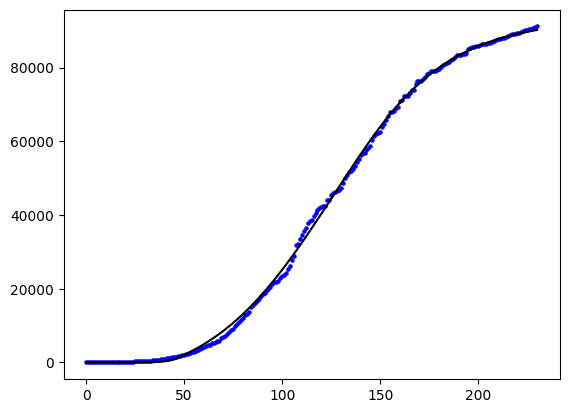

In [274]:
print(theta_max1)
b0, b1, b2, t1, t2, k, d, rr1 = theta_max1
params = b0, b1, b2, t1, t2, k, d
sol1 = solve_ivp(fun = het_model, t_span = [0, len(cen1)], args=(params,),y0= [N, 0, 1,0,0,0,0], t_eval=np.arange(len(cen1)))
plt.plot(np.arange(len(cen1)), rr1*sol1.y[5,:], color = 'k')
plt.scatter(np.arange(len(cen1)), cen1, s = 5, color = 'blue')
xcen1 = rr*sol1.y[5,:]
k

0.33569820621556906 0.36165338130048846 0.5225214158916689


157.39696679852122

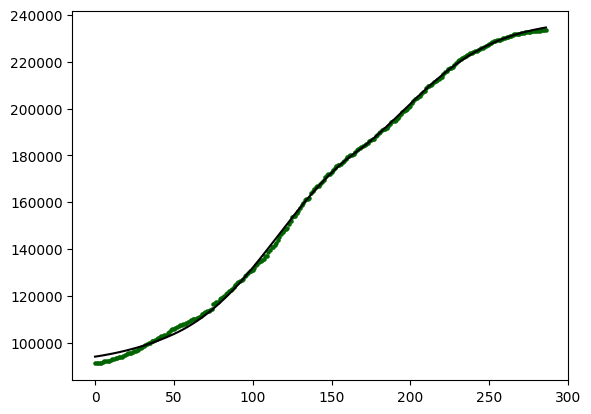

In [275]:

b0, b1, b2, t1, t2, k, d, rr21, rho21 = theta_max21
params = b0, b1, b2, t1, t2, k, d
S, E, I, R, D, NC, ND = S1, E1, I1, R1, D1, NC1, ND1
sol21 = solve_ivp(fun = het_model, t_span = [0, len(cen21)], args=(params,),y0 = [S+R*rho, E, I, R*(1-rho), D, NC, ND], t_eval=np.arange(len(cen21)))
plt.plot(np.arange(len(cen21)), rr21*sol21.y[5,:], color='k')
plt.scatter(np.arange(len(cen21)), cen21, s= 5, color='darkgreen')
print(b0,b1,b2)
k

0.07868260634211614 0.003072225958206926 0.08483667793741902 0.8221384540954989
23/12/2021


12.709289212560487

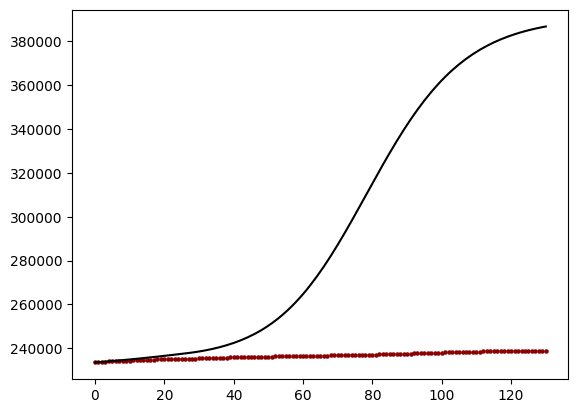

In [276]:

b0, b1, b2, t1, t2, k, d, rr22, rho22 = theta_max22
params = b0, b1, b2, t1, t2, k, d
S, E, I, R, D, NC, ND = S21, E21, I21, R21, D21, NC21, ND21
sol22 = solve_ivp(fun = het_model, t_span = [0, len(cen22)], args=(params,),y0 = [S+R*rho, E, I, R*(1-rho), D, NC, ND], t_eval=np.arange(len(cen22)))
plt.plot(np.arange(len(cen22)), rr22*sol22.y[5,:], color='k')
plt.scatter(np.arange(len(cen22)), cen22, s=5, color='darkred')
# print(len(cen1)+len(cen21)+t2)
print(1/k,d,rr22,rho)
print(data[len(cen1)+len(cen21)+len(cen22)])
k

0.01522205859925505 0.0001230871964135814 0.08460623399230868 0.8221384540954989


65.69413680019198

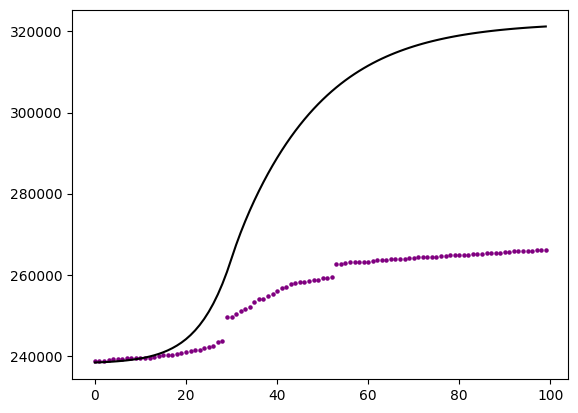

In [277]:
b0, b1, b2, t1, t2, k, d, rr3, rho3 = theta_max3
params = b0, b1, b2, t1, t2, k, d
S, E, I, R, D, NC, ND =  S22, E22, I22, R22, D22, NC22, ND22
sol3 = solve_ivp(fun = het_model, t_span = [0, len(yc)], args=(params,),y0 = [S+R*rho, E, I, R*(1-rho), D, NC, ND], t_eval=np.arange(len(yc)))
plt.plot(np.arange(len(cen3)), rr3*sol3.y[5,:], color='k')
plt.scatter(np.arange(len(cen3)), cen3, s=5, color='purple')

# print(len(cen1)+len(cen21)+len(cen22)+t2)
print(1/k,d,rr3,rho)
k

### Plot completo

(0.0, 2500.0)

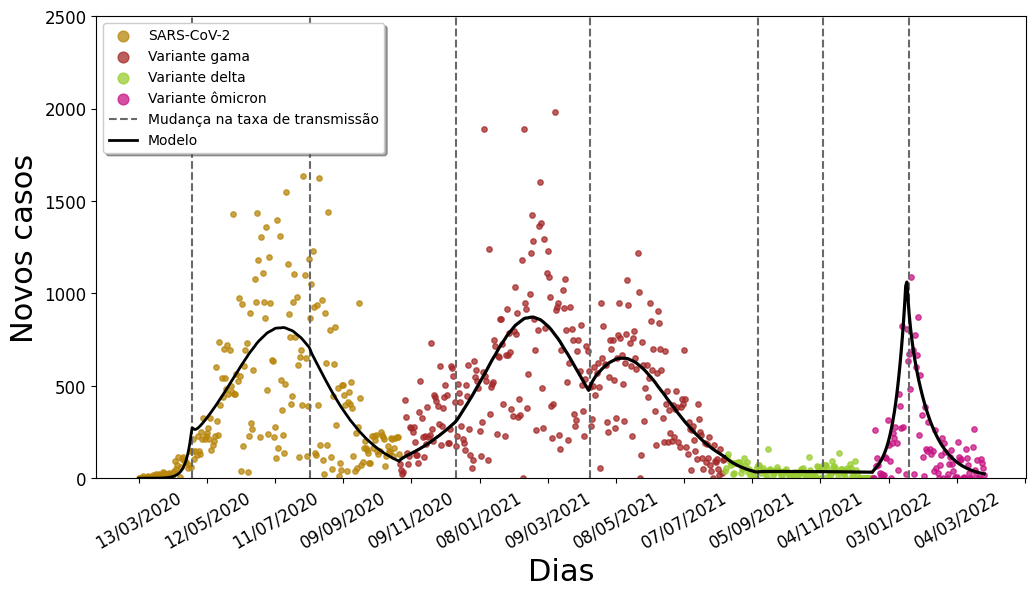

In [223]:

nwc1 = np.diff(cumu1)
nwc21 = np.diff(cumu21)
nwc22 = np.diff(cumu22)
nwc3 = np.diff(cumu3)

fig, ax = plt.subplots(figsize=(12,6))


ax.scatter(data[:230],np.diff(cen1), s=15, color='darkgoldenrod', alpha = 0.75, label='SARS-CoV-2')
ax.scatter(data[230:516],np.diff(cen21), s=15, color='brown', alpha = 0.75, label='Variante gama')
ax.scatter(data[516:646],np.diff(cen22), s=15, color='yellowgreen', alpha = 0.75, label='Variante delta')
ax.scatter(data[646:745],np.diff(cen3), s=15, color='mediumvioletred', alpha = 0.75,  label='Variante ômicron')


ax.axvline(data[47], 0, 600,c='dimgray',linestyle='--',label='Mudança na taxa de transmissão')
ax.axvline(data[151], 0, 600,c='dimgray',linestyle='--')
ax.axvline(data[279], 0, 600,c='dimgray',linestyle='--')
ax.axvline(data[397], 0, 600,c='dimgray',linestyle='--')
ax.axvline(data[545], 0, 600,c='dimgray',linestyle='--')
ax.axvline(data[602], 0, 600,c='dimgray',linestyle='--')
ax.axvline(data[678], 0, 600,c='dimgray',linestyle='--')

ax.plot(data[:230], nwc1, color='k',linewidth=2,label='Modelo')
ax.plot(data[230:516], nwc21, color='k',linewidth=2.3)
ax.plot(data[516:646], nwc22, color='k',linewidth=2.3)
ax.plot(data[646:745], nwc3, color='k',linewidth=2.3)

ax.legend(loc='upper left',fontsize=10,markerscale=2,shadow=True)
ax.tick_params(labelsize=12)

ax.set_ylabel('Casos diários',fontsize=22)
ax.set_xlabel('Dias',fontsize=22)

#Limiting the ammount of dates on the X axixs
ax.xaxis.set_major_locator(plt.MaxNLocator(15))
#Rotating the dates for better visualization
plt.setp(ax.get_xticklabels(), rotation=30)

ax.set_ylim(0,2500)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

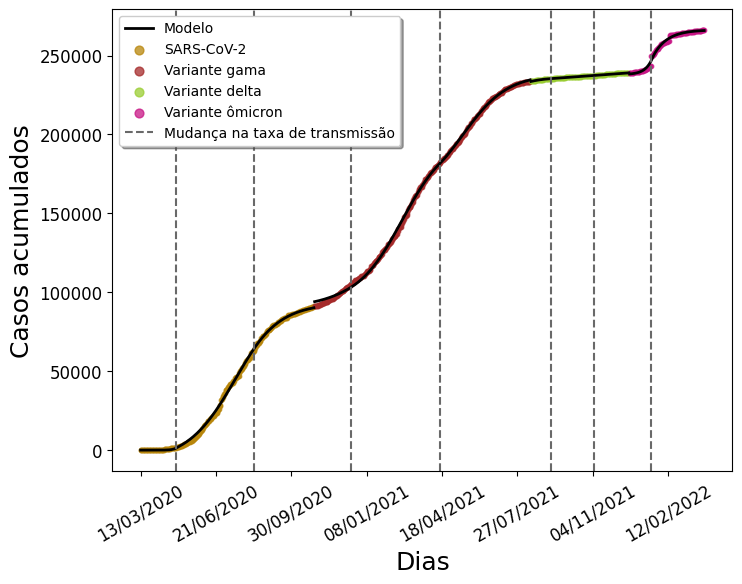

In [279]:
# cumu1 = rr1*sol1.y[5,:]
# cumu21 = rr21*sol21.y[5,:]
# cumu22 = rr22*sol22.y[5,:]
# cumu3 = rr3*sol3.y[5,:]


fig, ax = plt.subplots(figsize=(8,6))


ax.plot(data[:231], cumu1, color='k', label='Modelo',linewidth=2)
ax.plot(data[231:518], cumu21, color='k',linewidth=2)
ax.plot(data[518:649], cumu22, color='k',linewidth=2)
ax.plot(data[649:749], cumu3, color='k',linewidth=2)
ax.scatter(data[:231],cen1, s=10, color='darkgoldenrod', alpha = 0.75, label='SARS-CoV-2')
ax.scatter(data[231:518],cen21, s=10, color='brown', alpha = 0.75,label='Variante gama')
ax.scatter(data[518:649],cen22, s=10, color='yellowgreen', alpha = 0.75,label='Variante delta')
ax.scatter(data[649:749],cen3, s=10, color='mediumvioletred', alpha = 0.75, label='Variante ômicron')

ax.axvline(data[47], 0, 600,c='dimgray',linestyle='--',label='Mudança na taxa de transmissão')
ax.axvline(data[151], 0, 600,c='dimgray',linestyle='--')
ax.axvline(data[279], 0, 600,c='dimgray',linestyle='--')
ax.axvline(data[397], 0, 600,c='dimgray',linestyle='--')
ax.axvline(data[545], 0, 600,c='dimgray',linestyle='--')
ax.axvline(data[602], 0, 600,c='dimgray',linestyle='--')
ax.axvline(data[678], 0, 600,c='dimgray',linestyle='--')


ax.legend(loc='upper left',fontsize=10,markerscale=2,shadow=True)
ax.tick_params(labelsize=12)

ax.set_ylabel('Casos acumulados',fontsize=18)
ax.set_xlabel('Dias',fontsize=18)

#Limiting the ammount of dates on the X axixs
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
#Rotating the dates for better visualization
plt.setp(ax.get_xticklabels(), rotation=30)

#Limiting the ammount of dates on the X axixs
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
#Rotating the dates for better visualization
plt.setp(ax.get_xticklabels(), rotation=30)


# Corner

In [195]:
flat_samples.shape

(63000, 8)

(63000, 9)


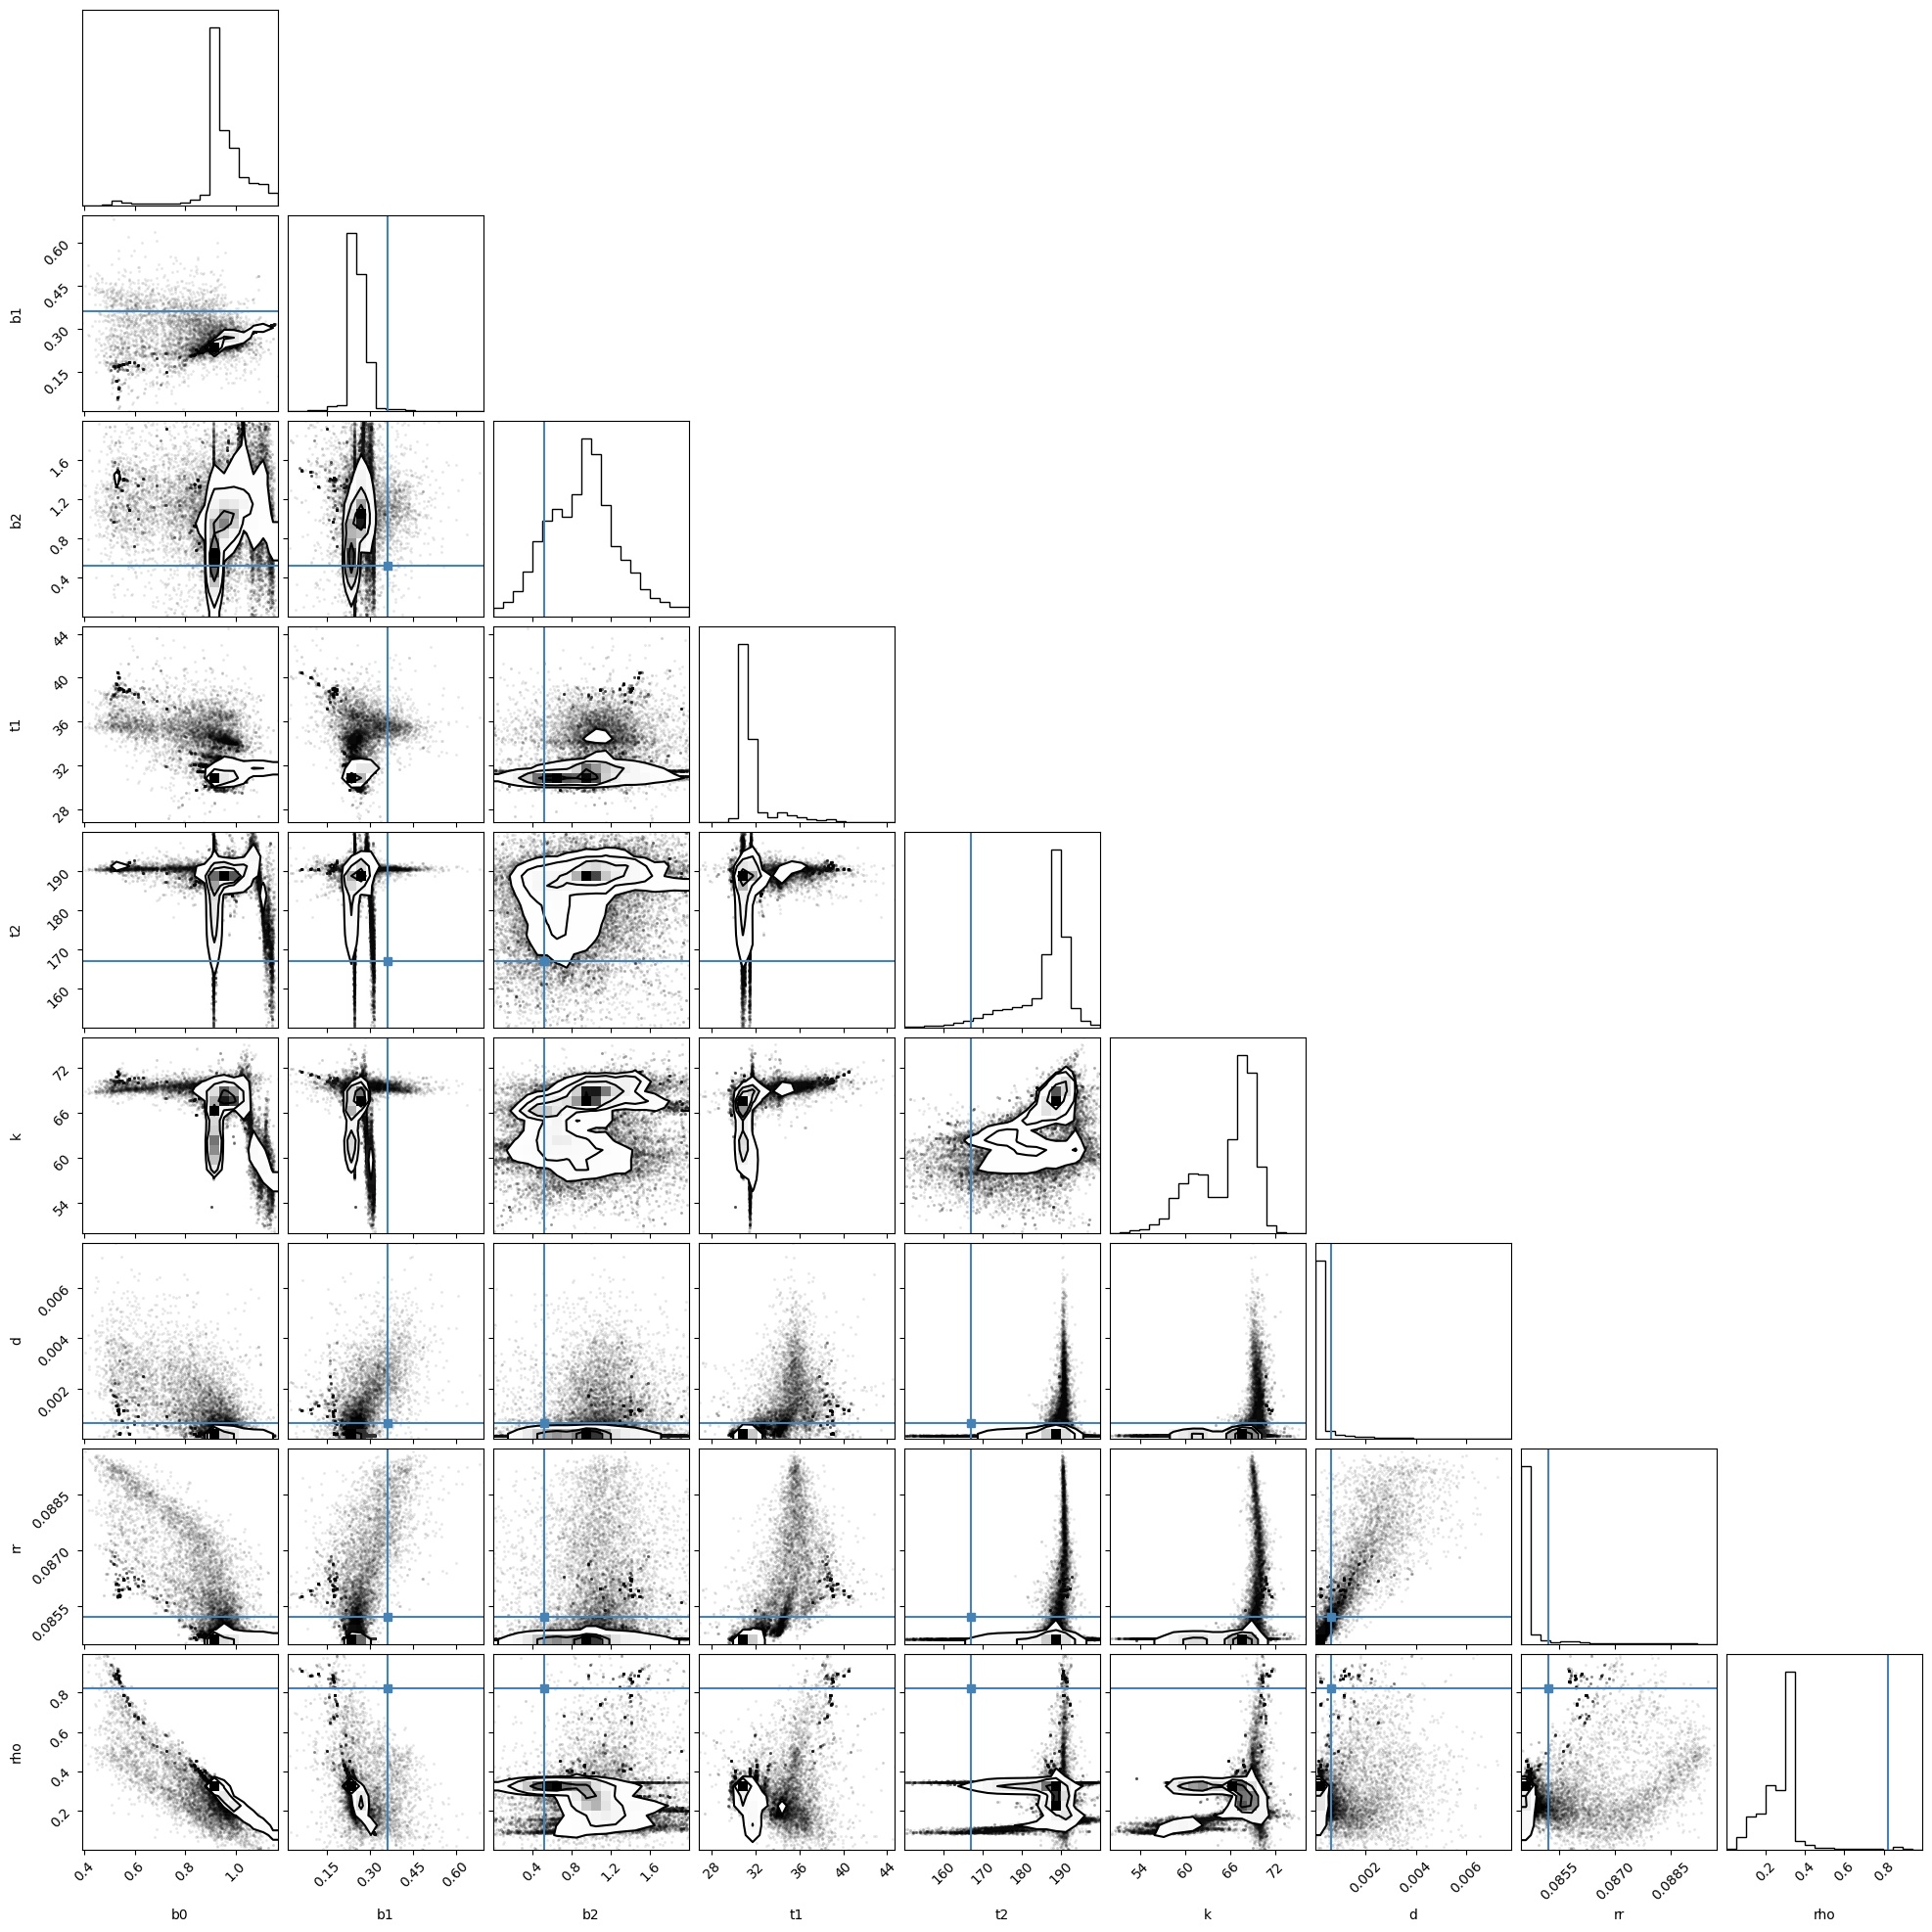

In [278]:
import corner
flat_samples = sampler22.get_chain(discard=100, thin=15, flat=True)
b0, b1, b2, t1, t2, k, d, rr22, rho = theta_max21
print(flat_samples.shape)
labels = ["b0","b1","b2","t1","t2","k","d","rr", "rho"]
fig = corner.corner(
    flat_samples, labels=labels, truths=[b0, b1, b2, t1, t2, k, d, rr22, rho]
);

In [269]:
print(S1+R*rho21,E1,I1,R1*(1-rho21),D1)
print(S21+R*rho22,E21,I21,R21*(1-rho22),D21)
print(S22+R*rho3,E22,I22,R22*(1-rho3),D22)


3009720.8689956563 6128.1787749350615 5047.656853107372 194992.94693063424 2809.859687939523
1358874.600866647 7555.567115706895 6216.178319030906 1432163.5418435629 7035.844207145265
2051944.0105191125 2106.2554250171174 1530.9937589820759 823246.4871742612 7871.253122628199
